In [24]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
# print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

import glob
import cv2
import matplotlib.pyplot as plt

import keras
from keras.applications.vgg19 import VGG19

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
import joblib

import torch
import torchvision.models as models

ModuleNotFoundError: No module named 'torch'

### Define function to store labels and images into a dictionary

In [2]:
def get_labels_images(filepath):
#     print('Entering function')
    data_dict = {}
    for directory in os.listdir(filepath):
#         print(directory)
        #A
    #         print('Entering loop')
    #         print(directory)
        for file in os.listdir(os.path.join(filepath,directory)):
            #a
#             print(file)
            images = []
            for file2 in os.listdir(os.path.join(filepath,directory,file)):
                #color**.png
#                 print(file2)
                if file2[:5]=='color':
                    images.append(os.path.join(filepath,directory,file,file2))
            data_dict.setdefault(file[-1],[]).extend(images)
#             data_dict[file[-1]].append(images)
        
    return data_dict

In [4]:
dataset_dir = "\\dataset5"
data_dict = get_labels_images(dataset_dir)
# glob.glob(dataset_dir)

### Display some images for sanity

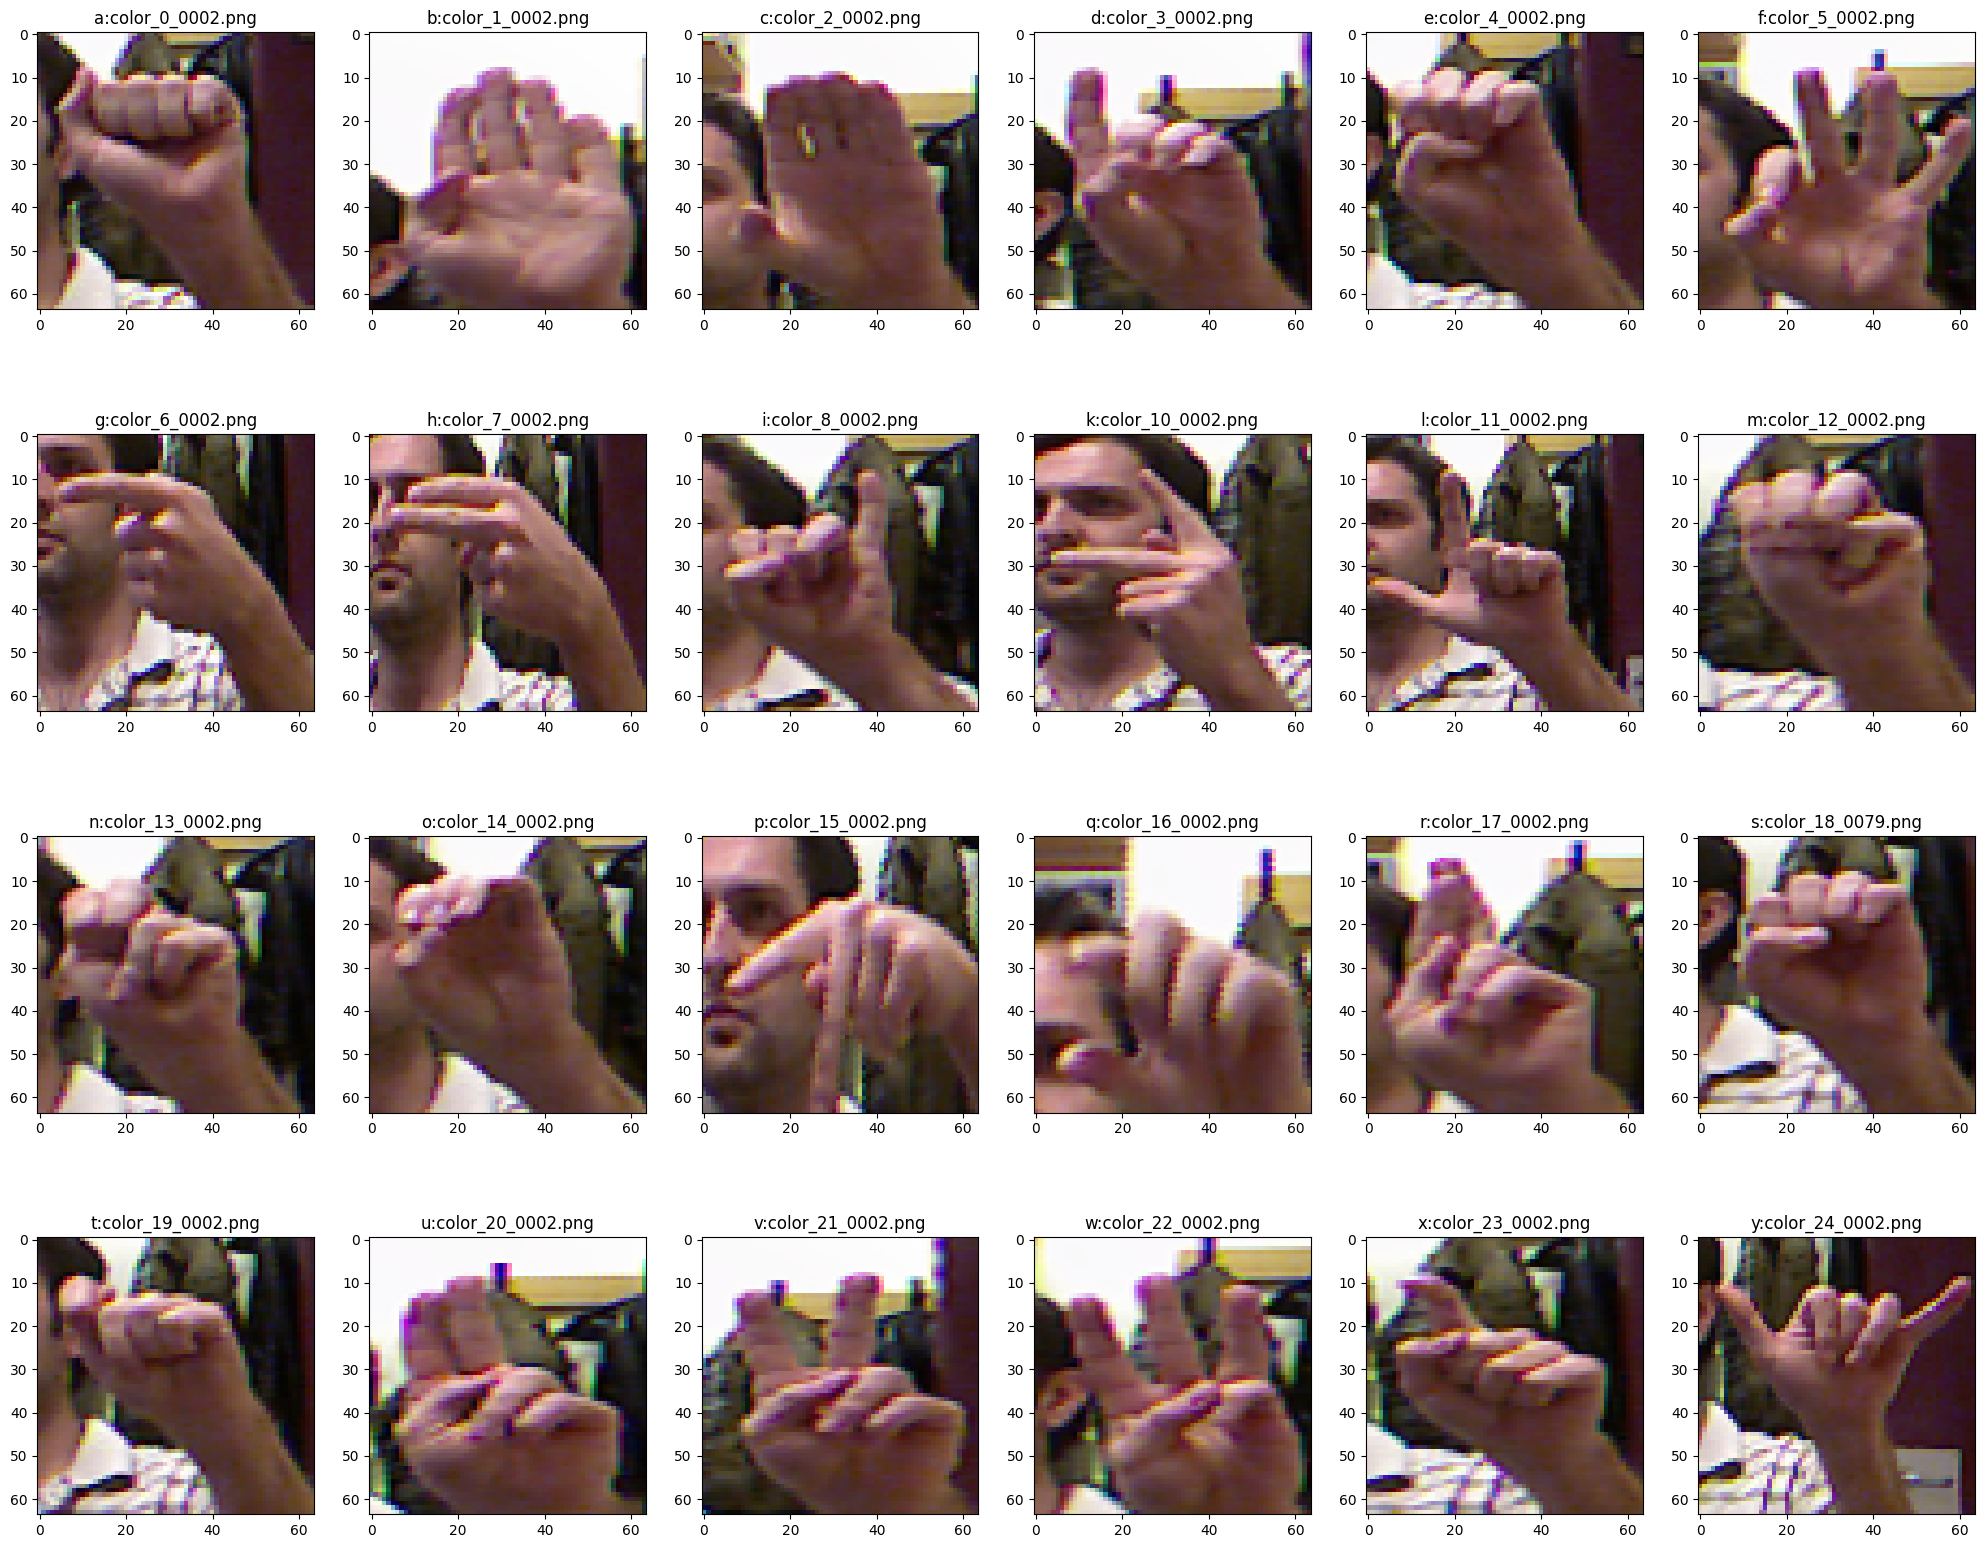

In [5]:
plt.figure(figsize = (25,20))

for i, (k,v) in enumerate(data_dict.items()):
    img = cv2.imread(v[0])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (64,64))
    plt.subplot(4,6,i+1)
    plt.imshow(img)
    plt.title(k + ":" + os.path.basename(v[0]))
    
plt.show()

### Analyzing Dataset

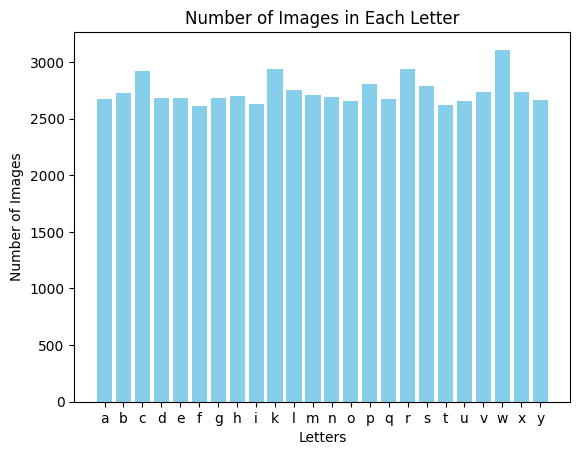

In [17]:
keys = list(data_dict.keys())
values_lengths = [len(value) for value in data_dict.values()]

# Plot the bar chart
plt.bar(keys, values_lengths, color='skyblue')
plt.xlabel('Letters')
plt.ylabel('Number of Images')
plt.title('Number of Images in Each Letter')
plt.show()

We can observe that data is distrubted uniformly between alphabets, and there is no alphabet with counts extremely high or extremely low.

### Define function to preprocess images

In [6]:
def preprocess_images(dictionary, height = 64, width = 64):
    images = []
    labels = []
    for k,v in dictionary.items():
        for file in v:
            img = cv2.imread(file)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (height, width))
            img = img / 255.
            images.append(img)
            labels.append(k)
    
    return (np.array(images), np.array(labels).reshape(-1,1))

images, labels = preprocess_images(data_dict)

### Skin Color Segmentation

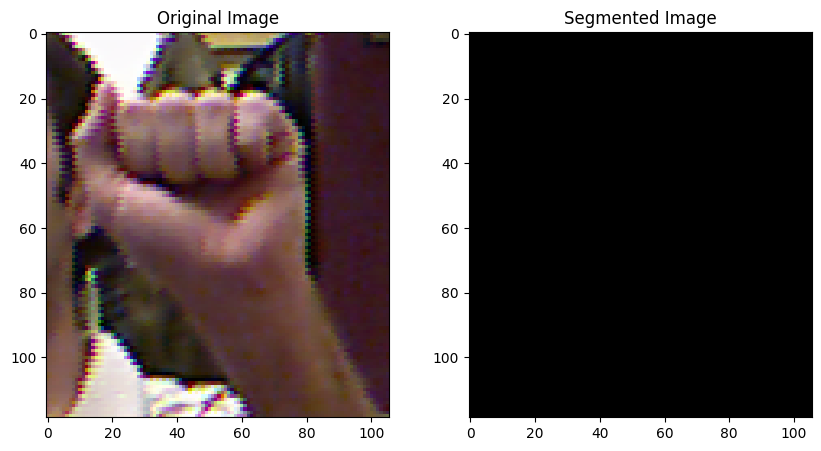

In [23]:
import cv2
import numpy as np  
import matplotlib.pyplot as plt

def skin_color_segmentation(image):
    # Convert the image to the YCbCr color space
    ycbcr_image = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)

    # Define a range for skin color in YCbCr space
    lower_skin = np.array([0, 133, 77], dtype=np.uint8)
    upper_skin = np.array([255, 173, 127], dtype=np.uint8)

    # Create a binary mask for skin color
    skin_mask = cv2.inRange(ycbcr_image, lower_skin, upper_skin)

    # Apply the mask to the original image
    segmented_image = cv2.bitwise_and(image, image, mask=skin_mask)

    return segmented_image

# Read an example image
image_path = "\\dataset5\\A\\a\\color_0_0002.png"
original_image = cv2.imread(image_path)

# Perform skin color segmentation
segmented_image = skin_color_segmentation(original_image)

# Display the original and segmented images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1), plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)), plt.title('Original Image')
plt.subplot(1, 2, 2), plt.imshow(cv2.cvtColor(segmented_image, cv2.COLOR_BGR2RGB)), plt.title('Segmented Image')
plt.show()


### Encode our labels

In [7]:
lbl_binarizer = LabelBinarizer()
labels = lbl_binarizer.fit_transform(labels)

In [12]:
joblib.dump(lbl_binarizer, 'labels.joblib')

['labels.joblib']

### Define function to create train, dev, test split

In [7]:

X_train, X_test, Y_train, Y_test = train_test_split(images, labels, test_size = 0.2, random_state = 1)
X_train, X_dev, Y_train, Y_dev = train_test_split(X_train, Y_train, test_size = 0.25, random_state = 1)

print('Number of training samples:{}, Shape: {}'.format(len(X_train), X_train.shape))
print('Number of dev samples:{}, Shape: {}'.format(len(X_dev), X_dev.shape))
print('Number of test samples:{}, Shape: {}'.format(len(X_test), X_test.shape))

Number of training samples:39464, Shape: (39464, 64, 64, 3)
Number of dev samples:13155, Shape: (13155, 64, 64, 3)
Number of test samples:13155, Shape: (13155, 64, 64, 3)


### Display some images for sanity

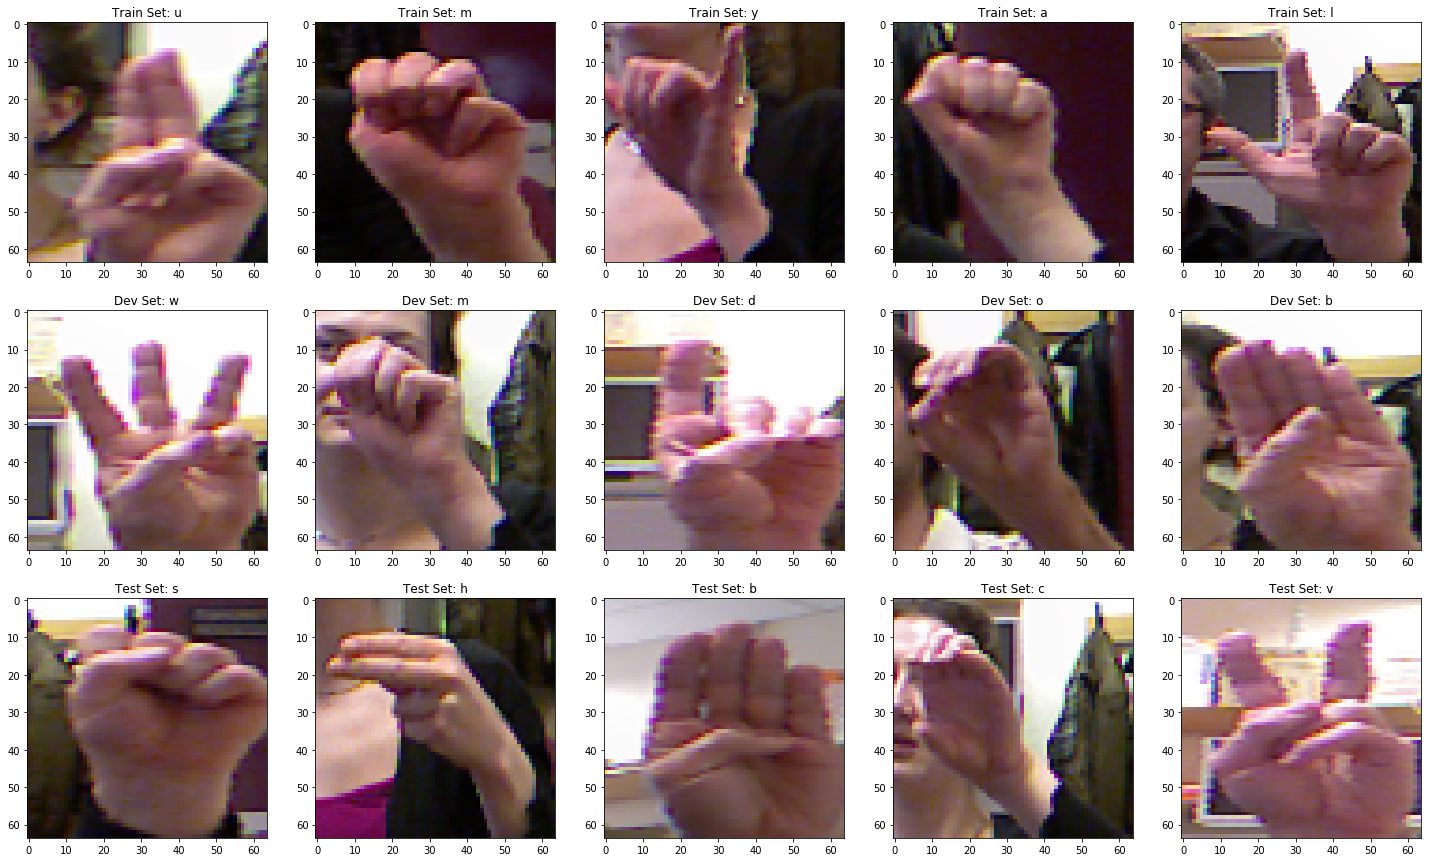

In [8]:
plt.figure(figsize = (25,15))

for i in range(5):
    plt.subplot(3,5,i+1)
    plt.imshow(X_train[i])
    plt.title('Train Set: {}'.format(lbl_binarizer.classes_[np.argmax(Y_train[i], axis = -1)]))

for i in range(5,10):
    plt.subplot(3,5,i+1)
    plt.imshow(X_dev[i])
    plt.title('Dev Set: {}'.format(lbl_binarizer.classes_[np.argmax(Y_dev[i], axis = -1)]))

for i in range(10,15):
    plt.subplot(3,5,i+1)
    plt.imshow(X_test[i])
    plt.title('Test Set: {}'.format(lbl_binarizer.classes_[np.argmax(Y_test[i], axis = -1)]))

plt.show()

### Build our model

#### Keras version

In [9]:
img_height = 64
img_width = 64
img_channels = 3
num_classes = labels.shape[1]
learning_rate = 1e-5
weights = '../input/vgg19/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5'

def build_model():
    base = VGG19(include_top = False, weights = weights, input_shape = (img_height, img_width, img_channels))
    X = base.output
    X = keras.layers.Flatten()(X)
    X = keras.layers.Dense(512, activation = 'relu')(X)
    X = keras.layers.Dropout(0.4)(X)
    X = keras.layers.BatchNormalization()(X)
    X = keras.layers.Dense(512, activation = 'relu')(X)
    X = keras.layers.Dropout(0.3)(X)
    X = keras.layers.BatchNormalization()(X)
    preds = keras.layers.Dense(num_classes, activation = 'softmax')(X)
    
    model = keras.models.Model(inputs = base.input, outputs = preds)
    model.compile(optimizer = keras.optimizers.RMSprop(lr = learning_rate), loss = 'categorical_crossentropy', metrics = ['accuracy'])
    
    return model

In [10]:
model = build_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0         
__________

#### PyTorch Version

### Define our callbacks and train our model

In [11]:
callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', patience = 5, verbose = 0, restore_best_weights = True)]

history = model.fit(X_train, Y_train,
                    epochs = 25,
                    batch_size = 128,
                    validation_data = (X_dev, Y_dev),
                    callbacks = callbacks)

Train on 39464 samples, validate on 13155 samples
Epoch 1/25
39464/39464 [==============================] - 78s 2ms/step - loss: 2.1393 - acc: 0.3954 - val_loss: 0.7468 - val_acc: 0.8011
Epoch 2/25
39464/39464 [==============================] - 68s 2ms/step - loss: 0.5524 - acc: 0.8563 - val_loss: 0.2583 - val_acc: 0.9431
Epoch 3/25
39464/39464 [==============================] - 69s 2ms/step - loss: 0.1726 - acc: 0.9636 - val_loss: 0.0984 - val_acc: 0.9738
Epoch 4/25
39464/39464 [==============================] - 69s 2ms/step - loss: 0.0715 - acc: 0.9876 - val_loss: 0.0482 - val_acc: 0.9889
Epoch 5/25
39464/39464 [==============================] - 69s 2ms/step - loss: 0.0357 - acc: 0.9944 - val_loss: 0.0208 - val_acc: 0.9954
Epoch 6/25
39464/39464 [==============================] - 69s 2ms/step - loss: 0.0182 - acc: 0.9974 - val_loss: 0.0735 - val_acc: 0.9743
Epoch 7/25
39464/39464 [==============================] - 69s 2ms/step - loss: 0.0107 - acc: 0.9985 - val_loss: 0.0049 - val_acc

### Plot our metrics

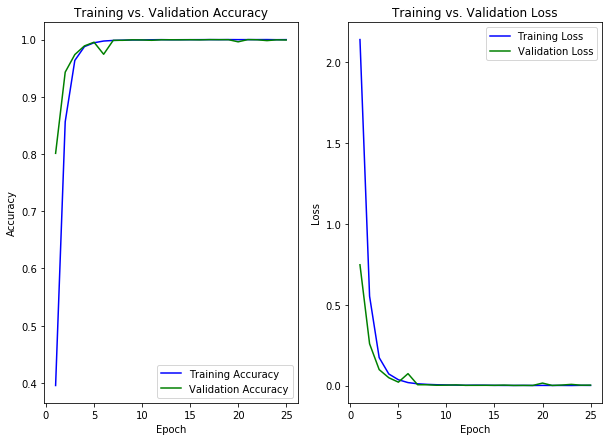

In [15]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize = (10, 7))

plt.subplot(1,2,1)
plt.plot(epochs, acc, c = 'b', label = 'Training Accuracy')
plt.plot(epochs, val_acc, c = 'g', label = 'Validation Accuracy')
plt.title('Training vs. Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, loss, c = 'b', label = 'Training Loss')
plt.plot(epochs, val_loss, c = 'g', label = 'Validation Loss')
plt.title('Training vs. Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

### Evaluate model on test set

In [16]:
eval_loss, eval_acc = model.evaluate(X_test, Y_test)
print('Evaluation Loss: {:.4f}, Evaluation Accuracy: {:.2f}'.format(eval_loss, eval_acc * 100))

13155/13155 [==============================] - 9s 671us/step
Evaluation Loss: 0.0034, Evaluation Accuracy: 99.88


### Make predictions

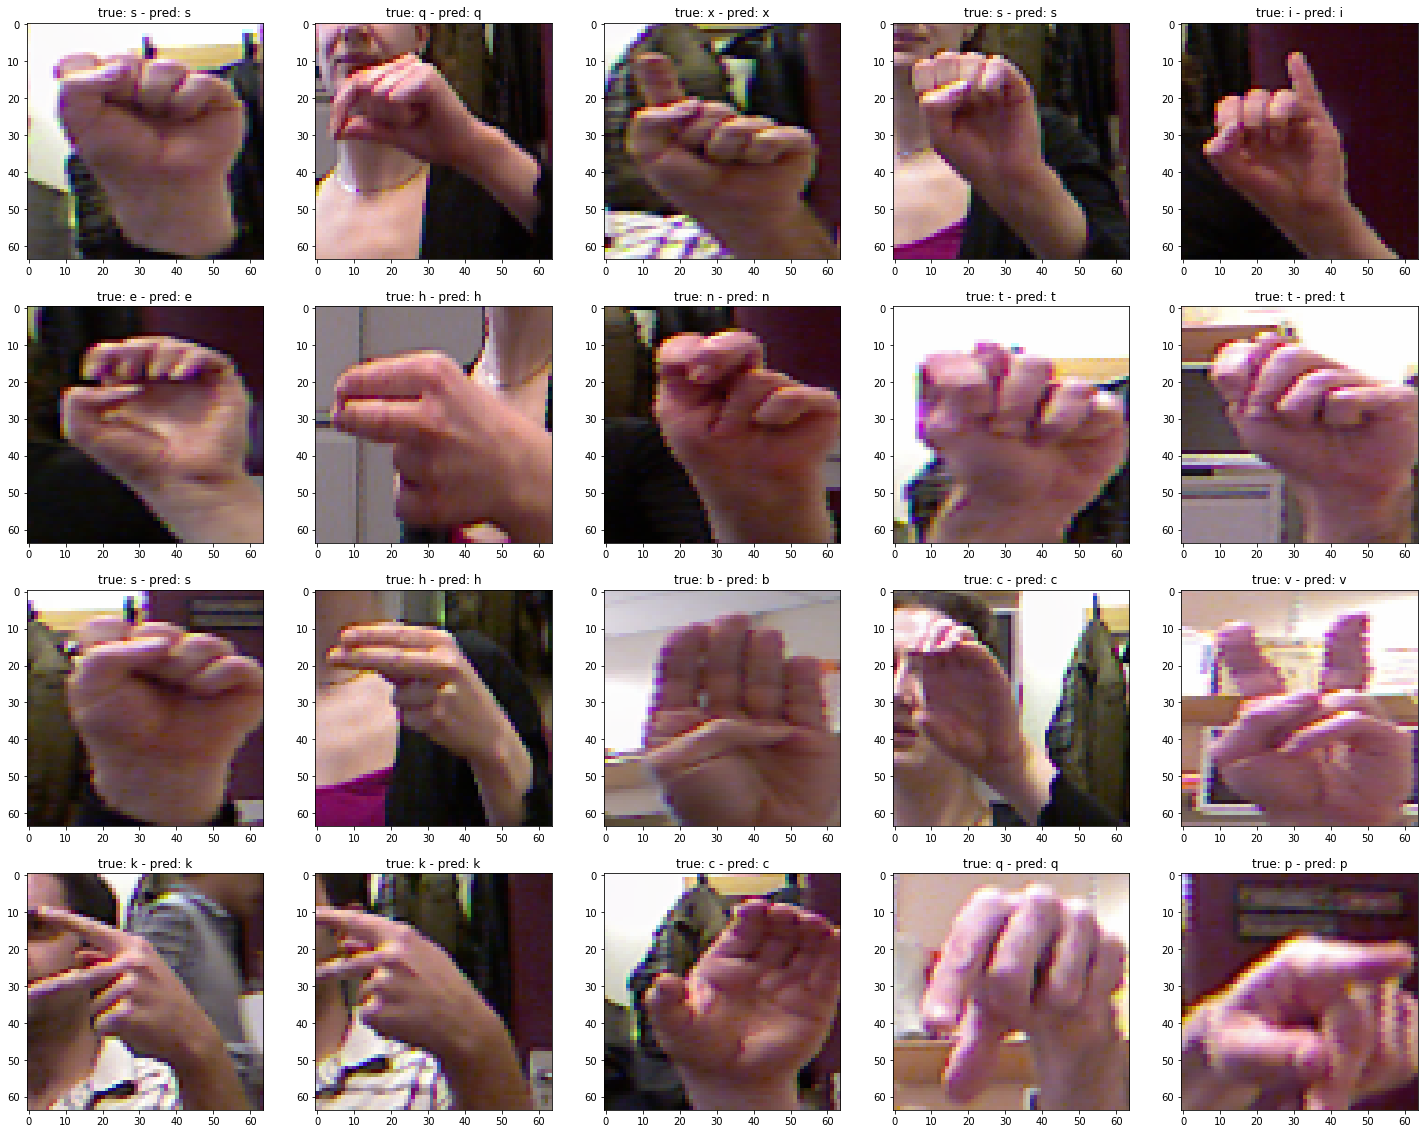

In [17]:
preds = model.predict(X_test)

plt.figure(figsize = (25,20))
for i in range(20):
    plt.subplot(4,5,i+1)
    plt.imshow(X_test[i])
    plt.title('true: {} - pred: {}'.format(lbl_binarizer.classes_[np.argmax(Y_test[i], axis = -1)], lbl_binarizer.classes_[np.argmax(preds[i], axis = -1)]))
    
plt.show()

### Test with custom images

In [ ]:
custom_images_path = '/kaggle/input/custom-img'

def prepare_custom_images(filepath, height = 64, width = 64):
    images = []
    for file in os.listdir(filepath):
        img = cv2.imread(os.path.join(filepath,file))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (height, width))
        img = img / 255.
        images.append(img)
    
    return np.array(images)

custom_images = prepare_custom_images(custom_images_path)

In [ ]:
custom_preds = model.predict(custom_images)

plt.figure(figsize = (25,20))
for i in range(len(custom_preds)):
    plt.subplot(1,2,i+1)
    plt.imshow(custom_images[i])
    plt.title('pred: {}'.format(lbl_binarizer.classes_[np.argmax(custom_preds[i], axis = -1)]))
    
plt.show()

### Save model

In [ ]:
model_path = '/kaggle/working/models/'
if not os.path.isdir(model_path): os.mkdir(model_path)

model.save('/kaggle/working/models/my_model_full_dataset.h5')

In [ ]:
import shutil
shutil.make_archive('/kaggle/working/models/', 'zip', '/kaggle/working/models/')

### Real time prediction

In [8]:
# Specify the path to the pretrained model file (.h5)
model_path = "models\\my_model_full_dataset.h5"

# Load the model
model = keras.models.load_model(model_path)

In [14]:
lbl_binarizer = joblib.load('labels.joblib')

In [9]:
def prepare_cust_images(img, height = 64, width = 64):
#     images = []
#     for file in os.listdir(filepath):
#         img = cv2.imread(os.path.join(filepath,file))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (height, width))
    img = img / 255.
    images=[img]
#         images.append(img)
    
    return np.array(images)

# custom_images = prepare_custom_images(custom_images_path)

In [11]:
# Initialize webcam
cap = cv2.VideoCapture(0)

while True:
    # Capture frame from webcam
    ret, frame = cap.read()

    # Preprocess the frame to match your model's input requirements
#     frame = cv2.resize(frame, (224, 224))  # Adjust the size based on your model's input size
#     frame = frame / 255.0  # Normalize pixel values
    
    
#     # Expand dimensions to match the model's expected input shape
#     frame = np.expand_dims(frame, axis=0)

#     # Make predictions
#     predictions = model.predict(frame)

#     # Get the predicted class label
#     predicted_class = class_labels[np.argmax(predictions)]
    
    new_frame = prepare_cust_images(frame)
    
    predicted_class = model.predict(new_frame)

#     plt.figure(figsize = (25,20))
#     for i in range(len(custom_preds)):
#         plt.subplot(1,2,i+1)
#         plt.imshow(custom_images[i])
#         plt.title('pred: {}'.format(lbl_binarizer.classes_[np.argmax(custom_preds[i], axis = -1)]))

    plt.show()
    # Display the frame and predicted class
    pred = lbl_binarizer.classes_[np.argmax(predicted_class, axis = -1)]
    cv2.putText(frame, f'Prediction: {pred}', (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    cv2.imshow('Webcam', frame)

    # Break the loop when 'q' key is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the webcam and close the OpenCV window
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 102ms/step
